## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [1]:
!pip install tensorflow-gpu

# Load Dataset Files

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import utils
from sklearn.model_selection import  train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Activation,Dropout, Dense,Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from tensorflow.keras import utils 
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import time

In [4]:
from google.colab import drive
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [5]:
project_path = "/gdrive/My Drive/Colab Notebooks/R8/Lab/CV/DogBreed"
project_path

'/gdrive/My Drive/Colab Notebooks/R8/Lab/CV/DogBreed'

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile(project_path+'/train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
with ZipFile(project_path+'/test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
with ZipFile(project_path+'/sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
with ZipFile(project_path+'/labels.csv.zip', 'r') as z:
  z.extractall()

In [11]:
!ls

labels.csv  sample_data  sample_submission.csv	test  train


After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
labels_df = pd.read_csv('labels.csv')

In [13]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset



In [14]:
print("Total number of dogs: ", labels_df.shape[0])
print("Total number of breeds: ", len(labels_df['breed'].unique()))

Total number of dogs:  10222
Total number of breeds:  120


In [15]:
print("Number of dogs from each breed")
print(labels_df.groupby("breed").count().sort_values(by="id", ascending=False))

Number of dogs from each breed
                       id
breed                    
scottish_deerhound    126
maltese_dog           117
afghan_hound          116
entlebucher           115
bernese_mountain_dog  114
...                   ...
golden_retriever       67
brabancon_griffon      67
komondor               67
briard                 66
eskimo_dog             66

[120 rows x 1 columns]


In [0]:
#Add file name in dataframe
labels_df['filename'] = labels_df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)

In [17]:
labels_df.head()

,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


### Get one-hot encodings of labels

In [18]:
# Label encoding
labelEncoder = LabelEncoder()
labels_df['breed'] = labelEncoder.fit_transform(labels_df['breed'].values)
labels_df['breed'].values

array([19, 37, 85, ...,  3, 75, 28])

In [0]:
# One hot encoding
labels_ohe  = utils.to_categorical(labels_df['breed'].values,  len(labels_df['breed'].unique()))

In [20]:
labels_ohe[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [21]:
print("Total Number of traning image: ",len(labels_ohe), "and total number of categoies: ", len(labels_ohe[0]))

Total Number of traning image:  10222 and total number of categoies:  120


## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [0]:
x_train_feature = []
ImageCount = labels_df.shape[0]

for i in range(ImageCount):
  image = cv2.imread('/content/train/' + labels_df.id[i]+'.jpg')
  image = cv2.resize(image, (128,128))
  x_train_feature.append(image)

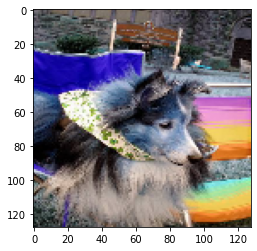

In [23]:
import matplotlib.pyplot as plt
plt.imshow(x_train_feature[10])
plt.show()

In [24]:
print('Total number of Image present: ', len(x_train_feature))

Total number of Image present:  10222


Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
x_train_feature = np.asarray(x_train_feature)
x_train_feature = x_train_feature/255
x_train_feature = x_train_feature.reshape(x_train_feature.shape[0], 128, 128, 3)

In [26]:
x_train_feature.shape

(10222, 128, 128, 3)

In [27]:
x_train_feature[0]

array([[[0.27058824, 0.45490196, 0.67843137],
        [0.14901961, 0.35686275, 0.53333333],
        [0.4       , 0.65098039, 0.8       ],
        ...,
        [0.50980392, 0.8       , 0.92941176],
        [0.33333333, 0.75686275, 0.8627451 ],
        [0.23137255, 0.54117647, 0.66666667]],

       [[0.16470588, 0.30196078, 0.4627451 ],
        [0.55686275, 0.70588235, 0.84705882],
        [0.46666667, 0.63529412, 0.77254902],
        ...,
        [0.31372549, 0.59607843, 0.76078431],
        [0.39607843, 0.71764706, 0.85490196],
        [0.29019608, 0.69411765, 0.83137255]],

       [[0.25490196, 0.41960784, 0.59215686],
        [0.22352941, 0.40392157, 0.57647059],
        [0.25882353, 0.41960784, 0.6       ],
        ...,
        [0.14509804, 0.4745098 , 0.6745098 ],
        [0.28627451, 0.56862745, 0.71764706],
        [0.25098039, 0.65882353, 0.81176471]],

       ...,

       [[0.30196078, 0.46666667, 0.74509804],
        [0.25882353, 0.4745098 , 0.72941176],
        [0.25882353, 0

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train_feature, labels_ohe, test_size=0.2, random_state=10)

In [29]:
print("X_train shape: ", X_train.shape[0], "Y_train shape: ", Y_train.shape[0])
print("X_val shape: ", X_val.shape[0], "Y_val shape: ", Y_val.shape[0])

X_train shape:  8177 Y_train shape:  8177
X_val shape:  2045 Y_val shape:  2045


### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [30]:
test_img = pd.read_csv("sample_submission.csv")['id']
test_img

0        000621fb3cbb32d8935728e48679680e
1        00102ee9d8eb90812350685311fe5890
2        0012a730dfa437f5f3613fb75efcd4ce
3        001510bc8570bbeee98c8d80c8a95ec1
4        001a5f3114548acdefa3d4da05474c2e
                       ...               
10352    ffeda8623d4eee33c6d1156a2ecbfcf8
10353    fff1ec9e6e413275984966f745a313b0
10354    fff74b59b758bbbf13a5793182a9bbe4
10355    fff7d50d848e8014ac1e9172dc6762a3
10356    fffbff22c1f51e3dc80c4bf04089545b
Name: id, Length: 10357, dtype: object

Run the below code to load the test image files in x_test_feature

In [31]:
import cv2
img_rows = 128
img_cols = 128
x_test_feature = []
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('./test/{}.jpg'.format(f))
    img_resize = cv2.resize(img, (img_rows, img_cols)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:28<00:00, 369.40it/s]


Normalize the test data and convert it into 4 dimensions

In [32]:
X_test = np.array(x_test_feature,dtype='float32')
X_test/=255
X_test[0]

array([[[0.2627451 , 0.43529412, 0.40784314],
        [0.30588236, 0.38431373, 0.4117647 ],
        [0.2627451 , 0.38039216, 0.36862746],
        ...,
        [0.03137255, 0.21960784, 0.14901961],
        [0.03921569, 0.44705883, 0.39607844],
        [0.04705882, 0.39607844, 0.34901962]],

       [[0.1254902 , 0.36078432, 0.3372549 ],
        [0.1254902 , 0.29411766, 0.30588236],
        [0.24313726, 0.43137255, 0.43137255],
        ...,
        [0.01568628, 0.34509805, 0.3019608 ],
        [0.00784314, 0.34901962, 0.27450982],
        [0.01568628, 0.43529412, 0.3647059 ]],

       [[0.12156863, 0.3137255 , 0.28627452],
        [0.2784314 , 0.43137255, 0.42352942],
        [0.31764707, 0.4627451 , 0.47843137],
        ...,
        [0.05098039, 0.35686275, 0.27058825],
        [0.        , 0.27450982, 0.18431373],
        [0.13333334, 0.58431375, 0.49019608]],

       ...,

       [[0.18431373, 0.34117648, 0.29803923],
        [0.15294118, 0.16078432, 0.14509805],
        [0.23921569, 0

In [33]:
print("X_test shape: ",X_test.shape)

X_test shape:  (10357, 128, 128, 3)


### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
keras.backend.clear_session()

#Adding conv layer
model = Sequential()

#Add first CNN layer
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(128,128,3), activation="relu", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

#Add 2nd CNN layer
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(128,128,3), activation="relu", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

#Adding dense layer
model.add(Flatten())
model.add(Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(units=120, activation='softmax'))


### Use batch_size = 128 and epochs = 10 and execute the model

In [35]:
BATCH_SIZE = 128
EPOCH = 10

#Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

#Train
start_time = time.time()
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=EPOCH, batch_size=BATCH_SIZE, verbose=True)
print("Model Train time: %s seconds" % (time.time() - start_time))

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 6s 776us/sample - loss: 7.5660 - accuracy: 0.0109 - val_loss: 6.2602 - val_accuracy: 0.0078
Epoch 2/10
8177/8177 [==============================] - 4s 472us/sample - loss: 4.7687 - accuracy: 0.0142 - val_loss: 23.1187 - val_accuracy: 0.0068
Epoch 3/10
8177/8177 [==============================] - 4s 471us/sample - loss: 4.7232 - accuracy: 0.0193 - val_loss: 35.8088 - val_accuracy: 0.0098
Epoch 4/10
8177/8177 [==============================] - 4s 472us/sample - loss: 4.6874 - accuracy: 0.0236 - val_loss: 36.0640 - val_accuracy: 0.0112
Epoch 5/10
8177/8177 [==============================] - 4s 471us/sample - loss: 4.6296 - accuracy: 0.0342 - val_loss: 19.7693 - val_accuracy: 0.0152
Epoch 6/10
8177/8177 [==============================] - 4s 470us/sample - loss: 4.5451 - accuracy: 0.0432 - val_loss: 6.7113 - val_accuracy: 0.0220
Epoch 7/10
8177/8177 [==============================] - 4s 4

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
train_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=False, vertical_flip=True,
                                   featurewise_center=True, featurewise_std_normalization=True)

val_datagen = ImageDataGenerator()

In [0]:
train_datagen.fit(X_train)
val_datagen.fit(X_val)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = train_datagen.flow(X_train, Y_train)

In [0]:
val_generator = val_datagen.flow(X_val, Y_val)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [40]:
start_time = time.time()
model.fit(train_generator, validation_data = val_generator, epochs = EPOCH, verbose=True)
print("Model Train time: %s seconds" % (time.time() - start_time))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 256 steps, validate for 64 steps
Epoch 1/10
256/256 [==============================] - 30s 117ms/step - loss: 4.8118 - accuracy: 0.0113 - val_loss: 4.7838 - val_accuracy: 0.0112
Epoch 2/10
256/256 [==============================] - 29s 114ms/step - loss: 4.7838 - accuracy: 0.0100 - val_loss: 4.7840 - val_accuracy: 0.0117
Epoch 3/10
256/256 [==============================] - 29s 115ms/step - loss: 4.7857 - accuracy: 0.0109 - val_loss: 4.7828 - val_accuracy: 0.0112
Epoch 4/10
256/256 [==============================] - 29s 113ms/step - loss: 4.7789 - accuracy: 0.0104 - val_loss: 4.7828 - val_accuracy: 0.0112
Epoch 5/10
256/256 [==============================] - 29s 113ms/step - loss: 4.7778 - accuracy: 0.0109 - val_loss: 4.7828 - val_accuracy: 0.0112
Epoch 6/10
256/256 [==============================] - 29s 113ms/step - loss: 4.7775 - accuracy: 0.0095 - val_loss: 4.7828 - val_accuracy: 0.0112
Epoch 7/10
256/256 [=================

In [41]:
model.evaluate(val_generator)

  ...
    to  
  ['...']
64/64 [==============================] - 0s 6ms/step - loss: 4.7833 - accuracy: 0.0112


[4.783316016197205, 0.011246944]

# Model accuracy is still poor!!!

## **Lets use Transfer Learning**

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

**Use the below code to load VGG16 weights trained on ImageNet**

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg', input_tensor=Input(shape=(128,128,3)))

Print the summary of the base_model

In [43]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
model_1 = Sequential(name="VGG16_model1")
model_1.add(base_model)

# Flatten layer
model_1.add(Flatten())

# 1st dense layer
model_1.add(Dense(units=1024, activation='relu'))
model_1.add(Dropout(0.3))

#2nd dense layer
model_1.add(Dense(units=256, activation='relu'))
model_1.add(Dropout(0.3))

#Output layer
model_1.add(Dense(units=120, activation='softmax'))

**Make all the layers in the base_model (VGG16) to be non-trainable**

In [45]:
for layer in base_model.layers:
  layer.trainable = False
  
for layer in base_model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
False:	global_average_pooling2d


### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [46]:
model_1.compile(loss = 'categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(lr=0.0001),metrics = ['accuracy'])

# Train the model
start_time = time.time()
model_1.fit(train_generator, validation_data = val_generator, epochs = EPOCH, verbose=True,)
print("VGG16 Model Train time: %s seconds" % (time.time() - start_time))


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 256 steps, validate for 64 steps
Epoch 1/10
256/256 [==============================] - 32s 126ms/step - loss: 4.8042 - accuracy: 0.0114 - val_loss: 4.7609 - val_accuracy: 0.0156
Epoch 2/10
256/256 [==============================] - 31s 120ms/step - loss: 4.7175 - accuracy: 0.0216 - val_loss: 4.7133 - val_accuracy: 0.0220
Epoch 3/10
256/256 [==============================] - 31s 121ms/step - loss: 4.5929 - accuracy: 0.0407 - val_loss: 4.6205 - val_accuracy: 0.0342
Epoch 4/10
256/256 [==============================] - 31s 120ms/step - loss: 4.3918 - accuracy: 0.0600 - val_loss: 4.5144 - val_accuracy: 0.0362
Epoch 5/10
256/256 [==============================] - 31s 120ms/step - loss: 4.1906 - accuracy: 0.0818 - val_loss: 4.4300 - val_accuracy: 0.0430
Epoch 6/10
256/256 [==============================] - 31s 120ms/step - loss: 4.0267 - accuracy: 0.1010 - val_loss: 4.3332 - val_accuracy: 0.0631
Epoch 7/10
256/256 [=================

In [49]:
model_1.evaluate(val_generator)

  ...
    to  
  ['...']
64/64 [==============================] - 2s 28ms/step - loss: 4.1331 - accuracy: 0.0836


[4.133126549422741, 0.08361858]

Use VGG16 model for predicting test image class label

In [50]:
Y_Pred = model_1.predict(X_test)
Pred_class = np.argmax(Y_Pred, axis=1)
print("Test Image predicted class: ",Pred_class)

Test Image predicted class:  [ 94  94  52 ...  94 110  10]


### **Use the below code to load ResNet50 weights trained on ImageNet**

In [0]:
keras.backend.clear_session()

#ResNet50
base_model2 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(128,128,3)), pooling='avg')

In [0]:
for layer in base_model2.layers:
    layer.trainable = False
    #print("{0}:\t{1}".format(layer.trainable, layer.name))

In [0]:
model_2 = Sequential(name="Model_2")
model_2.add(base_model2)

# Flatten layer
model_2.add(Flatten())

# 1st dense layer
model_2.add(Dense(units=1024, activation='relu'))
model_2.add(Dropout(0.25))

#2nd dense layer
model_2.add(Dense(units=256, activation='relu'))
model_2.add(Dropout(0.25))

#Output layer
model_2.add(Dense(units=120, activation='softmax'))

In [56]:
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001),metrics = ['accuracy'])

# Train the model
start_time = time.time()
model_2.fit(train_generator, validation_data=val_generator, epochs=10, verbose=True)
print("ResNet50 Model Train time: %s seconds" % (time.time() - start_time))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 256 steps, validate for 64 steps
Epoch 1/10
256/256 [==============================] - 37s 143ms/step - loss: 4.7679 - accuracy: 0.0231 - val_loss: 4.8231 - val_accuracy: 0.0049
Epoch 2/10
256/256 [==============================] - 33s 129ms/step - loss: 4.3775 - accuracy: 0.0712 - val_loss: 4.8328 - val_accuracy: 0.0078
Epoch 3/10
256/256 [==============================] - 33s 127ms/step - loss: 3.9466 - accuracy: 0.1306 - val_loss: 4.8380 - val_accuracy: 0.0112
Epoch 4/10
256/256 [==============================] - 32s 126ms/step - loss: 3.6136 - accuracy: 0.1754 - val_loss: 4.8497 - val_accuracy: 0.0093
Epoch 5/10
256/256 [==============================] - 32s 127ms/step - loss: 3.3911 - accuracy: 0.2125 - val_loss: 4.8583 - val_accuracy: 0.0103
Epoch 6/10
256/256 [==============================] - 32s 127ms/step - loss: 3.2356 - accuracy: 0.2408 - val_loss: 4.8673 - val_accuracy: 0.0103
Epoch 7/10
256/256 [=================

In [57]:
model_2.evaluate(val_generator)

  ...
    to  
  ['...']
64/64 [==============================] - 2s 29ms/step - loss: 4.9289 - accuracy: 0.0098


[4.92891027033329, 0.009779952]

Use ResNet50 model for predicting class test image

In [58]:
Y_Pred = model_2.predict(X_test)
Pred_class = np.argmax(Y_Pred, axis=1)
print("Test Image predicted class: ",Pred_class)

Test Image predicted class:  [88 88 88 ... 88 88 88]


### **Use the below code to load InceptionV3 weights trained on ImageNet**

In [0]:
keras.backend.clear_session()

#InceptionV3
base_model3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(128,128,3)), pooling='avg')

In [0]:
#base_model3.summary()

In [0]:
for layer in base_model3.layers:
    layer.trainable = False
    #print("{0}:\t{1}".format(layer.trainable, layer.name))

In [0]:
model_3 = Sequential(name="Model_3")
model_3.add(base_model3)

# Flatten layer
model_3.add(Flatten())

# 1st dense layer
model_3.add(Dense(units=1024, activation='relu'))
model_3.add(Dropout(0.25))

#2nd dense layer
model_3.add(Dense(units=256, activation='relu'))
model_3.add(Dropout(0.25))

#Output layer
model_3.add(Dense(units=120, activation='softmax'))

In [63]:
model_3.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.0001), metrics = ['accuracy'])

# Train the model
start_time = time.time()
model_3.fit(train_generator, validation_data=val_generator, epochs=10,verbose=True)
print("ResNet152 Model Train time: %s seconds" % (time.time() - start_time))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 256 steps, validate for 64 steps
Epoch 1/10
256/256 [==============================] - 38s 148ms/step - loss: 4.8324 - accuracy: 0.0092 - val_loss: 4.8257 - val_accuracy: 0.0186
Epoch 2/10
256/256 [==============================] - 32s 126ms/step - loss: 4.7864 - accuracy: 0.0135 - val_loss: 4.7483 - val_accuracy: 0.0284
Epoch 3/10
256/256 [==============================] - 32s 125ms/step - loss: 4.7772 - accuracy: 0.0126 - val_loss: 4.7950 - val_accuracy: 0.0381
Epoch 4/10
256/256 [==============================] - 32s 126ms/step - loss: 4.7626 - accuracy: 0.0160 - val_loss: 4.6622 - val_accuracy: 0.0582
Epoch 5/10
256/256 [==============================] - 32s 123ms/step - loss: 4.7458 - accuracy: 0.0186 - val_loss: 4.7631 - val_accuracy: 0.0567
Epoch 6/10
256/256 [==============================] - 32s 123ms/step - loss: 4.7118 - accuracy: 0.0257 - val_loss: 4.6470 - val_accuracy: 0.0763
Epoch 7/10
256/256 [=================

In [64]:
model_3.evaluate(val_generator)

  ...
    to  
  ['...']
64/64 [==============================] - 2s 29ms/step - loss: 5.0241 - accuracy: 0.1027


[5.024134896695614, 0.10268949]

Use InceptionV3 model for predicting class test image

In [65]:
Y_Pred = model_3.predict(X_test)
Pred_class = np.argmax(Y_Pred, axis=1)
print("Test Image predicted class: ",Pred_class)

Test Image predicted class:  [ 61  94 100 ...  83 100  70]


# Conclusion:

Tried multiple combination combination but model accuracy is pretty bad.

Model 1: Basic CNN model with 2 conv layer and 2 dense layer. Model accuracy is bad.

Model 2: Applied Data Augmentation and build above model again but Data Augmentation did not helped in increasing model accuracy.

Model 3: Used tranfer learning VGG16 pretrained weights, with extra dense layer. Small increase in accuracy is seen. If all layers are trainable then accuracy is very bad. Better accuracy is seen is all layers are not trainable.

Model 4: Used transfer learning ResNet50 pretrained weights, with extra dense layer. Again small increase in accuracy is seen. If all layers are trainable then accuracy is very bad. Better accuracy is seen is all layers are not trainable.

Model 5: Used tranfer learning InceptionV3 pretrained weights, with extra dense layer. Again small increase in accuracy is seen, but accuracy did not crossed 90%. If all layers are trainable then accuracy is very bad. Better accuracy is seen is all layers are not trainable.

Tried to build all model with different image size but google colab is crashing frequently. I am able run only with (128,128) image size. I also tried to take less number of image and then increase image size. Reduced number of image = 4000 and image size changed to (224, 224) and (300, 300) in both case accuracy is not increasing. Hence final model I build using all 10k images of size (128,128).

Also tried to set different data agumentation parameter, but that did not resulted in accuracy increase.

Number of epoch=100 and 10 both have similar accuracy.